<a href="https://colab.research.google.com/github/pchernic/python_for_financial_data/blob/main/Financial_Portfolio_Risk_Assessment_and_Monte_Carlo_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Question

In the world of finance and investment, assessing portfolio risk and estimating probabilities of profit are crucial for making informed decisions. This notebook addresses two key business questions:

1. **How to estimate probabilities of profit for a given portfolio in the last year:** Understanding the likelihood of profit in historical data is essential for evaluating the past performance of a portfolio.

2. **What are the probabilities of profit in this portfolio according to a given number of Monte Carlo Simulations:** Monte Carlo simulations offer a powerful tool for forecasting the future performance of a portfolio and assessing risk under different scenarios.

This notebook explores these questions and provide insights into portfolio risk and potential profit scenarios. By leveraging financial analysis and Monte Carlo simulations, I aim to empower investors and financial analysts to make more informed and data-driven investment decisions.



## Key points:

1. The ability to calculate metrics like Value at Risk (VAR) for different confidence intervals.
2. The assessment of whether the portfolio's risk aligns with the risk tolerance.
3. The model's utility in helping investors and financial analysts quantify and analyze portfolio risk.
4. The simulation of various scenarios and the assessment of potential outcomes.
5. The support in making more informed investment decisions.


## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from numpy import linalg as LA

## Creating Stock Portfolio and Getting Data

In [3]:


stocks = ['AAPL', 'TSLA', 'AMD', 'AMZN', 'GOOGL']
#stocks = [acao + ".SA" for acao in stocks] # .SA only for BR stock market

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=300)

prices = yf.download(stocks, start_date, end_date)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


## Returns and Covariance Matrix

In [21]:
# Returns and Covariance Matrix

returns = prices.pct_change().dropna()
avg_returns = returns.mean()
cov_matrix = returns.cov()
weights = np.full(len(stocks), 1/len(stocks)) # Setting equal weights, which may change in a real-world scenario
stock_number = len(stocks)

weights


array([0.2, 0.2, 0.2, 0.2, 0.2])

## Synthetic Returns
`Synthetic Returns = Average Returns + Rpdf × L`

### Definitions:
- `Average Returns`: The mean returns of the dataset.
- `Rpdf`: A random matrix generated from a specified density function.
- `L`: Lower Triangular Matrix obtained from the Cholesky decomposition of the covariance matrix calculated from the original data.

### Explanation:
In this section, we calculate synthetic returns (`Synthetic Returns`) by adding the product of the Random Matrix (`Rpdf`) and the Lower Triangular Matrix (`L`) to the Average Returns.

**Note:** We use Cholesky decomposition to transform the original data's covariance matrix into the Lower Triangular Matrix (`L`). This transformation is necessary to ensure a proper representation of the relationships between variables.



## Why Do This?
---

We assume that the distribution of returns follows a multivariate normal distribution (an expansion of the normal distribution).

When we generate random returns for each asset (e.g., AAPL, TSLA, AMD, AMZN, GOOGL), we create uncorrelated random vectors. In the real world, returns are correlated. To account for this, we need to introduce correlations among these returns, and to do so, we utilize the triangular matrix obtained from the covariance.



## Building a Triangular Matrix



In [24]:
# Monte Carlo Premises
n_simulations = 10000  # Number of simulation runs
days = 252  # Number of trading days in a year
initial_capital = 1000  # Initial capital for the simulation


In [22]:
#Mean returns
mean_returns = returns.mean(axis = 0).to_numpy()
mean_returns_matrix = mean_returns * np.ones(shape = (days, stock_number))

In [23]:
#Generating L
L = LA.cholesky(cov_matrix)
L

array([[ 0.0136248 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.01207246,  0.02736173,  0.        ,  0.        ,  0.        ],
       [ 0.00875926,  0.00738003,  0.01805962,  0.        ,  0.        ],
       [ 0.01013901,  0.00494001,  0.00683371,  0.01377415,  0.        ],
       [ 0.01752131,  0.00719014,  0.00542307, -0.00042947,  0.03040783]])

In [25]:
# Generating Simulations

portfolio_returns = np.zeros([days, n_simulations])  # Each column is a simulation
final_amounts = np.zeros(n_simulations)

for s in range(n_simulations):
    Rpdf = np.random.normal(size=(days, stock_number))
    synthetic_returns = mean_returns_matrix + np.inner(Rpdf, L)  # The only random component is Rpdf

    # Calculate portfolio returns for each simulation
    portfolio_returns[:, s] = np.cumprod(np.inner(weights, synthetic_returns) + 1) * initial_capital

    # Record the final amount for each simulation
    final_amounts[s] = portfolio_returns[-1, s]

portfolio_returns


array([[1018.08186161, 1030.75190585, 1022.97126545, ...,  976.62989573,
        1003.21772126,  990.28805337],
       [ 989.92070058, 1033.72203872, 1049.30853961, ...,  964.30856611,
        1008.98885659,  975.39196293],
       [1005.51447649, 1030.11757426, 1027.95692114, ...,  957.2927628 ,
        1002.63416658,  970.79637882],
       ...,
       [1276.80418151, 1309.70333268, 1457.9349294 , ..., 3561.08182265,
        2086.74209941, 1434.59880524],
       [1264.38469563, 1286.80598807, 1397.932736  , ..., 3552.36344184,
        2090.91183804, 1431.70119379],
       [1240.60307728, 1326.15775724, 1397.23980602, ..., 3515.87120413,
        2090.18364195, 1475.21974181]])

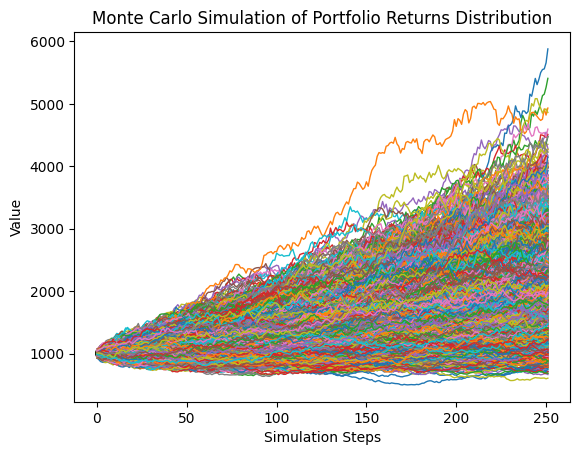

In [26]:
# Plot the Distribution of Portfolio Returns
plt.plot(portfolio_returns, linewidth=1)
plt.ylabel('Value')
plt.xlabel('Simulation Steps')
plt.title('Monte Carlo Simulation of Portfolio Returns Distribution')
plt.show()


In [27]:
# Calculate Percentiles and Profit Scenarios
amount_1st_percentile = np.percentile(amount_final, 1)
amount_5th_percentile = np.percentile(amount_final, 5)
amount_median = np.percentile(amount_final, 50)
profit_percentage = (len(amount_final[amount_final > 1000]) / len(amount_final)) * 100

# Format results as strings for display
amount_1st_percentile_str = f'{amount_1st_percentile:.2f}'
amount_5th_percentile_str = f'{amount_5th_percentile:.2f}'
amount_median_str = f'{amount_median:.2f}'
profit_percentage_str = f'{profit_percentage:.2f}%'


In [28]:
print(f''' Investing $ {initial_capital} in the following {stocks},
according to {n_simulations} Monte Carlo Simulations,
we may expect returns in the following probabilities:

- Probability 50%, the amount will be greater than $ {amount_median_str}.

- Probability 95%, the amount will be greater than $ {amount_5th_percentile_str}.

- Probability 99%, the amount will be greater than $ {amount_1st_percentile_str}.

In {profit_percentage_str} of scenarios, there is a probability of profit in the next year''')


 Investing $ 1000 in the following ['AAPL', 'TSLA', 'AMD', 'AMZN', 'GOOGL'],
according to 10000 Monte Carlo Simulations, 
we may expect returns in the following probabilities:

- Probability 50%, the amount will be greater than $ 1828.48.

- Probability 95%, the amount will be greater than $ 1151.13.

- Probability 99%, the amount will be greater than $ 942.31.

In 98.31% of scenarios, there is a probability of profit in the next year


# Insights offered by this analysis

Using these metrics, it's possible to calculate things like the portfolio's **Value at Risk (VAR)** for different confidence intervals and assess whether the risk you are taking aligns with your risk tolerance. In the case of this portfolio, a decline of 27.5% falls within the 95% of the most likely scenarios for the next year.

This **model's utility lies in its ability to help investors and financial analysts quantify and analyze portfolio risk,** allowing them to make more informed decisions regarding their investments. **By simulating various scenarios and assessing the range of potential outcomes, it provides valuable insights into the likelihood of different portfolio performance levels** and **helps users manage their risk exposure effectively.**

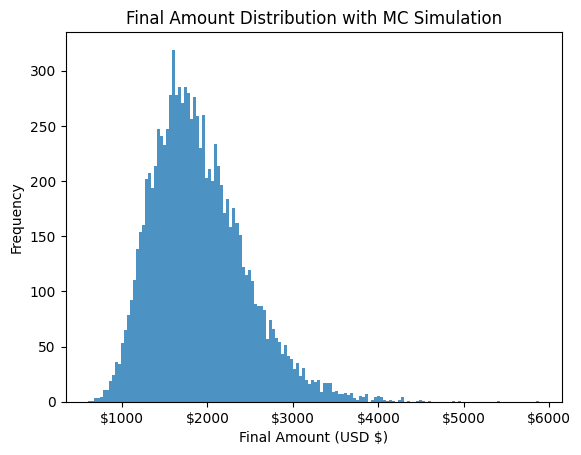

In [33]:
config = dict(histtype="stepfilled", alpha=0.8, density=False, bins=150)
fig, ax = plt.subplots()
ax.hist(final_amounts, **config)
ax.xaxis.set_major_formatter('${x:.0f}')
plt.title('Final Amount Distribution with MC Simulation')
plt.xlabel('Final Amount (USD $)')
plt.ylabel('Frequency')
plt.show()
